# Title and description

I work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. 
    
My task is to identify patterns that determine whether a game succeeds or not. This will allow me to spot potential big winners and plan advertising campaigns.
The data is going back to 2016. I am planning a campaign for 2017.

<div style="padding: 15px;">
<b>Initialization</b></div>

Loading all the libraries

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
import copy
import warnings
warnings.filterwarnings('ignore')

<div style="padding: 15px;">
<b>Load data</b></div>

In [2]:
df = pd.read_csv('moved_games.csv')

In [3]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df.describe(include='all')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


Everything looks good, but in ['User_Score'] we have some non-numeric value 'tbd' ('to be determined'). All columns must be lowercase. And what is interesting, that in sales everywhere we have first quartile 0 (25%), that means, that more than a quarter of the games had no sales in the considered region, and for Japan - more than half. Most likely, the data included games primarily focused on the American and European markets.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().mean().sort_values(ascending=False)*100

Critic_Score       51.319174
Rating             40.478612
User_Score         40.089740
Year_of_Release     1.609333
Name                0.011965
Genre               0.011965
Platform            0.000000
NA_sales            0.000000
EU_sales            0.000000
JP_sales            0.000000
Other_sales         0.000000
dtype: float64

We see that there are missing values in columns ['Critic_Score'], ['Rating'], ['User_Score'], ['Year_of_Release'], ['Name'] and ['Genre'].

Also we see wrong types of columns. ['Year_of_Release'] must be int type. ['User_Score'] must be float, but we have value 'tbd' in it.

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [10]:
df[(df.name.isna()) | (df.genre.isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
df[(df.platform == 'GEN')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
145,Sonic the Hedgehog 2,GEN,1992.0,Platform,4.47,1.20,0.16,0.19,NaN,NaN,NaN
257,Sonic the Hedgehog,GEN,1991.0,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN
564,Mortal Kombat,GEN,1992.0,Fighting,1.95,0.63,0.00,0.09,NaN,NaN,NaN
588,Streets of Rage,GEN,1990.0,Action,1.86,0.55,0.11,0.08,NaN,NaN,NaN
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
832,NBA Jam,GEN,1992.0,Sports,1.75,0.25,0.00,0.05,NaN,NaN,NaN
960,Sonic & Knuckles,GEN,1994.0,Platform,1.24,0.43,0.03,0.12,NaN,NaN,NaN
996,Sonic the Hedgehog 3,GEN,1994.0,Platform,1.02,0.47,0.20,0.07,NaN,NaN,NaN
1099,Street Fighter II': Special Champion Edition,GEN,1992.0,Fighting,1.00,0.30,0.31,0.04,NaN,NaN,NaN
1365,Disney's The Lion King,GEN,1994.0,Platform,0.97,0.37,0.03,0.05,NaN,NaN,NaN


I tried to google, but i didn't find what is this game on row 659. But I don't want to delete this game, because it brought a lot of money in NA area (5th place for this platform), so i decided to fill in name to 'unknown' and genre to most popular genre in this platform.

And with row 14244 I'll do the same.

In [12]:
df.query('platform == "GEN"')['genre'].describe(include='all').top

'Platform'

In [13]:
df.iloc[659]

name                  NaN
platform              GEN
year_of_release    1993.0
genre                 NaN
na_sales             1.78
eu_sales             0.53
jp_sales              0.0
other_sales          0.08
critic_score          NaN
user_score            NaN
rating                NaN
Name: 659, dtype: object

In [14]:
df.iloc[14244]

name                  NaN
platform              GEN
year_of_release    1993.0
genre                 NaN
na_sales              0.0
eu_sales              0.0
jp_sales             0.03
other_sales           0.0
critic_score          NaN
user_score            NaN
rating                NaN
Name: 14244, dtype: object

In [15]:
df.at[659, 'genre'] = 'Platform'

In [16]:
df.at[14244, 'genre'] = 'Platform'

In [17]:
df.name = df.name.fillna('unknown')

In [18]:
df.iloc[659]

name                unknown
platform                GEN
year_of_release      1993.0
genre              Platform
na_sales               1.78
eu_sales               0.53
jp_sales                0.0
other_sales            0.08
critic_score            NaN
user_score              NaN
rating                  NaN
Name: 659, dtype: object

In [19]:
df.iloc[14244]

name                unknown
platform                GEN
year_of_release      1993.0
genre              Platform
na_sales                0.0
eu_sales                0.0
jp_sales               0.03
other_sales             0.0
critic_score            NaN
user_score              NaN
rating                  NaN
Name: 14244, dtype: object

Next, I'll try to fill in the year_of_release of games that are on another platform and have a release year

In [20]:
df[df.year_of_release.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [21]:
df.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [22]:
df.query('name == "FIFA Soccer 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003.0,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


In [23]:
df['year_of_release'] = df['year_of_release'].fillna(df.groupby('name')['year_of_release'].transform('max'))

In [24]:
df.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [25]:
df.query('name == "FIFA Soccer 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,2003.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003.0,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


In [26]:
df.year_of_release.unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.,   nan])

In [27]:
df.year_of_release.isna().sum()

146

Left 146 titles. We can not fill in missing values here, then I'll remove them.

In [28]:
df = df.dropna(how='any', subset = ['year_of_release'])
df['year_of_release'].isna().sum()

0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16569 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16569 non-null  object 
 1   platform         16569 non-null  object 
 2   year_of_release  16569 non-null  float64
 3   genre            16569 non-null  object 
 4   na_sales         16569 non-null  float64
 5   eu_sales         16569 non-null  float64
 6   jp_sales         16569 non-null  float64
 7   other_sales      16569 non-null  float64
 8   critic_score     8075 non-null   float64
 9   user_score       9934 non-null   object 
 10  rating           9868 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


I think we can't fill in missing values in columns [critic_score], [user_score] and [rating], cause even for one title and different platform we can have different values here. For example we have 'Need for Speed: Most Wanted' on different platforms, and we have different [critic_score], [user_score] and [rating]. And we can't fill in those values with mean/median cause port of game can be very bad (as 'Need for Speed: Most Wanted' on DS that has critic_score = 45, and user_score = 6.1)

Example:

In [30]:
df[df.name == 'Need for Speed: Most Wanted']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


For `rating` it is better to fill in the missing values with "unknown". This will be very helpful when I will analyze the TOP 5 ratings in each region.

In [31]:
df['rating'] = df['rating'].fillna('unknown')

Next step - 'tbd':

In [32]:
df[df.user_score=='tbd']['year_of_release'].value_counts(sort=False)

year_of_release
2010.0    333
2005.0    122
2011.0    218
2009.0    405
2004.0    107
1999.0      8
2001.0     82
2008.0    330
2007.0    193
2003.0     96
2000.0     43
2006.0    127
2002.0    195
2015.0     38
2014.0     21
2012.0     26
2013.0     15
2016.0     34
1997.0      1
Name: count, dtype: int64

I think 'tbd' is not necessary to hold for our analysis, cause it is not any score, it is lack of score or NaN. So we can change 'tbd' to NaN and we will have opportunity to see statistics (describe()) of column [user_score].

And I'll save data with value 'tbd', if we'll need it in data_with_tbd.

In [33]:
data_with_tbd = copy.deepcopy(df)
data_with_tbd.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16569,16569,16569.000000,16569,16569.000000,16569.000000,16569.000000,16569.000000,8075.000000,9934,16569
unique,11427,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,9
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,unknown
freq,12,2140,NaN,3342,NaN,NaN,NaN,NaN,NaN,2394,6701
mean,NaN,NaN,2006.490253,NaN,0.264050,0.145828,0.078013,0.047567,68.991950,NaN,NaN
std,NaN,NaN,5.863759,NaN,0.816512,0.505343,0.310050,0.187466,13.923383,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


In [34]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN).astype('float')

In [35]:
df.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16569,16569,16569.000000,16569,16569.000000,16569.000000,16569.000000,16569.000000,8075.000000,7540.000000,16569
unique,11427,31,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,9
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN,unknown
freq,12,2140,NaN,3342,NaN,NaN,NaN,NaN,NaN,NaN,6701
mean,NaN,NaN,2006.490253,NaN,0.264050,0.145828,0.078013,0.047567,68.991950,7.125027,NaN
std,NaN,NaN,5.863759,NaN,0.816512,0.505343,0.310050,0.187466,13.923383,1.498254,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,NaN


In [36]:
data_with_tbd.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16569,16569,16569.000000,16569,16569.000000,16569.000000,16569.000000,16569.000000,8075.000000,9934,16569
unique,11427,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,9
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,unknown
freq,12,2140,NaN,3342,NaN,NaN,NaN,NaN,NaN,2394,6701
mean,NaN,NaN,2006.490253,NaN,0.264050,0.145828,0.078013,0.047567,68.991950,NaN,NaN
std,NaN,NaN,5.863759,NaN,0.816512,0.505343,0.310050,0.187466,13.923383,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


Last step I need to create column with total sales:

In [37]:
df['total_sales']=df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


In [38]:
df.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
count,16569,16569,16569.000000,16569,16569.000000,16569.000000,16569.000000,16569.000000,8075.000000,7540.000000,16569,16569.000000
unique,11427,31,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN
freq,12,2140,NaN,3342,NaN,NaN,NaN,NaN,NaN,NaN,6701,NaN
mean,NaN,NaN,2006.490253,NaN,0.264050,0.145828,0.078013,0.047567,68.991950,7.125027,NaN,0.535458
std,NaN,NaN,5.863759,NaN,0.816512,0.505343,0.310050,0.187466,13.923383,1.498254,NaN,1.554259
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,NaN,0.000000
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,NaN,0.060000
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,NaN,0.170000
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,NaN,0.470000


Intermediate conclusion:

I prepared the data for further work. What was done: checked for duplicates, filled in some missing values, some of the data had to be deleted, because the missing values could not be filled in (146 rows without the year of release, which is less than 1% of all data).

And also for further analysis, the column total_sales was added, which considers the total profit from all regions.

<div style="padding: 15px;">
<b>Analyze the data</b></div>

1. How many games were released in different years? Is the data for every period significant?

In [39]:
games_by_years=df[['year_of_release','name']].groupby(['year_of_release'])['name'].nunique().reset_index()
games_by_years

,year_of_release,name
0,1980.0,9
1,1981.0,46
2,1982.0,36
3,1983.0,17
4,1984.0,14
5,1985.0,14
6,1986.0,21
7,1987.0,16
8,1988.0,15
9,1989.0,17


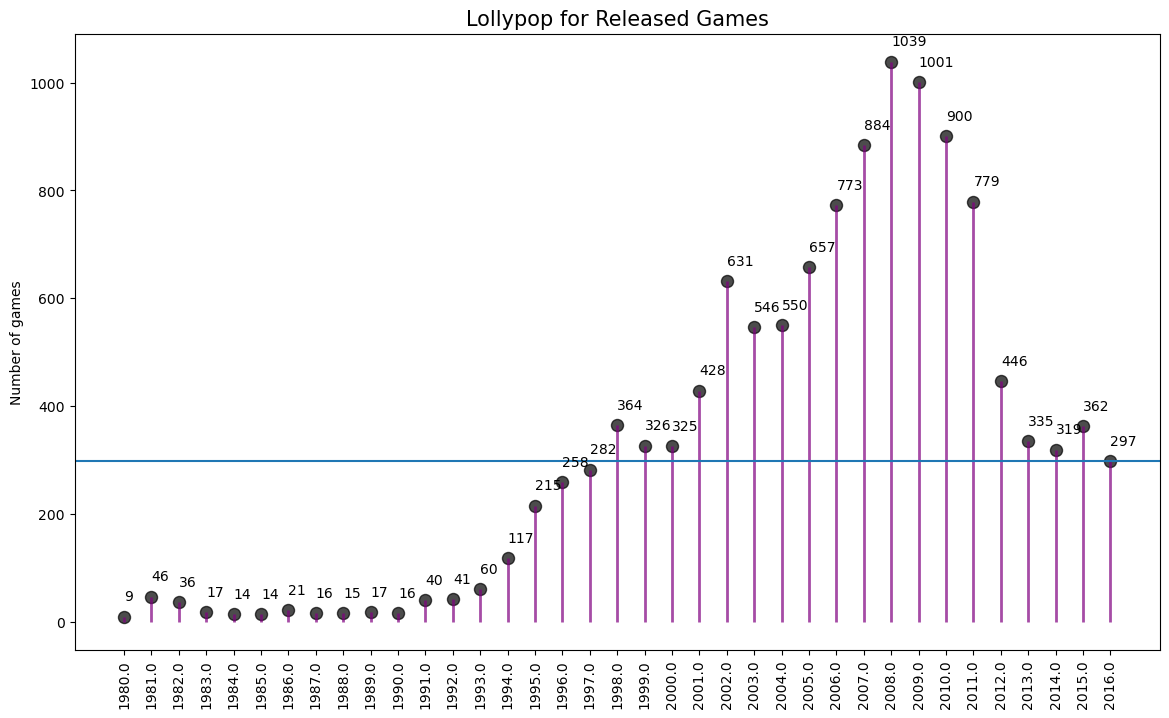

In [40]:
fig,ax=plt.subplots(figsize=(14,8))
ax.vlines(x=games_by_years.year_of_release, ymin=0, ymax=games_by_years.name, color='purple', alpha=0.7, linewidth=2)
ax.scatter(x=games_by_years.year_of_release,y=games_by_years.name, s=75, color='black',alpha=0.7)

ax.set_title("Lollypop for Released Games", fontdict={'size':15})
ax.set_ylabel('Number of games')
ax.set_xticks(games_by_years.year_of_release)
ax.set_xticklabels(games_by_years.year_of_release,rotation=90)
ax.axhline(y=games_by_years.name.median())

for row in games_by_years.itertuples():
    ax.text(row.year_of_release, row.name+30,s=row.name)
plt.show()

Conclusion: we see big peak of count of games from 2002 until 2011. From 1980 until 1994 there were not so many games. From 2012 until now we have overall median of count of games.

2. Look at how sales varied from platform to platform.

In [41]:
sales_by_platform=df[['platform','total_sales']].groupby(['platform']).sum().sort_values(by='total_sales').reset_index()
sales_by_platform

,platform,total_sales
0,PCFX,0.03
1,GG,0.04
2,3DO,0.10
3,TG16,0.16
4,WS,1.42
5,NG,1.44
6,SCD,1.86
7,DC,15.95
8,GEN,30.77
9,SAT,33.59


I'll calculate z-score that tells us how far is value from mean in terms of standard deviation.

In [42]:
sales_by_platform['sales_z']=(sales_by_platform['total_sales']-sales_by_platform['total_sales'].mean())/sales_by_platform['total_sales'].std()
sales_by_platform

,platform,total_sales,sales_z
0,PCFX,0.03,-0.826000
1,GG,0.04,-0.825971
2,3DO,0.10,-0.825798
3,TG16,0.16,-0.825625
4,WS,1.42,-0.821988
5,NG,1.44,-0.821930
6,SCD,1.86,-0.820718
7,DC,15.95,-0.780048
8,GEN,30.77,-0.737270
9,SAT,33.59,-0.729131


In [43]:
sales_by_platform['color']=['red' if x<0 else 'green' for x in sales_by_platform['sales_z']]
sales_by_platform

,platform,total_sales,sales_z,color
0,PCFX,0.03,-0.826000,red
1,GG,0.04,-0.825971,red
2,3DO,0.10,-0.825798,red
3,TG16,0.16,-0.825625,red
4,WS,1.42,-0.821988,red
5,NG,1.44,-0.821930,red
6,SCD,1.86,-0.820718,red
7,DC,15.95,-0.780048,red
8,GEN,30.77,-0.737270,red
9,SAT,33.59,-0.729131,red


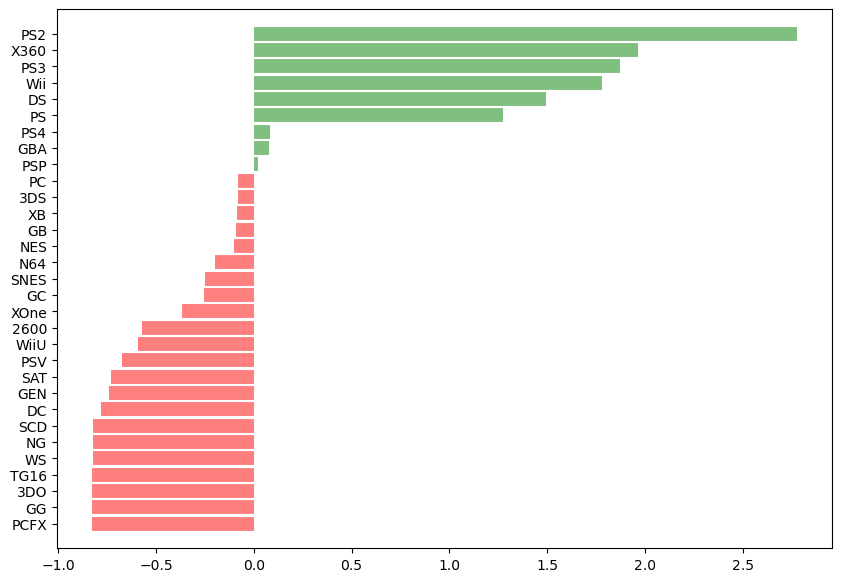

In [44]:
plt.figure(figsize=(10,7))
plt.hlines(y=sales_by_platform.platform,xmax=sales_by_platform.sales_z, xmin=0,color=sales_by_platform.color, alpha=0.5, linewidth=10)
plt.show()

Conclusion: PS2 has greatest total sales over all.

3. Choose the platforms with the greatest total sales and build a distribution based on data for each year.

In [45]:
platform_years_sales = df.groupby(['platform', 'year_of_release'])['total_sales'].agg('sum').reset_index()
top_3_platform = platform_years_sales.query('platform == "PS2" | platform == "X360" | platform == "PS3"')
top_3_platform

,platform,year_of_release,total_sales
133,PS2,2000.0,39.17
134,PS2,2001.0,166.43
135,PS2,2002.0,208.36
136,PS2,2003.0,193.05
137,PS2,2004.0,211.81
138,PS2,2005.0,160.66
139,PS2,2006.0,104.24
140,PS2,2007.0,76.10
141,PS2,2008.0,53.90
142,PS2,2009.0,26.40


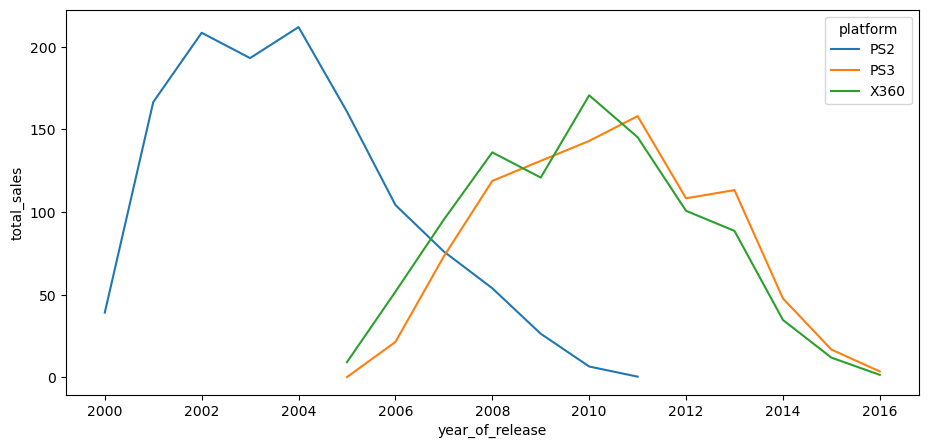

In [46]:
plt.figure(figsize=(11,5))
ax = sns.lineplot(data=top_3_platform, x="year_of_release", y="total_sales",hue="platform")

We see that PS2 had big peak in past, PS3 and X360 have almost the same distribution and their life cycle almost finished.

4. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

For this task I think will be better to take platforms since 1995, because earlier than this year I think data is not relevant to our time. Also until 1995 we didn't have many games, we saw it on "Lollypop for Released Games" graph above.

In [47]:
df_since_1995=df[df.year_of_release>=1995]

In [48]:
df_age=df_since_1995.groupby(['platform'])['year_of_release'].agg(['min','max'])
df_age

,min,max
platform,,
2600,2002.0,2002.0
3DO,1995.0,1995.0
3DS,2010.0,2016.0
DC,1998.0,2008.0
DS,2004.0,2013.0
GB,1995.0,2001.0
GBA,2000.0,2007.0
GC,2001.0,2007.0
N64,1996.0,2004.0


In [49]:
df_age['age']=df_age['max']-df_age['min']
df_age

,min,max,age
platform,,,
2600,2002.0,2002.0,0.0
3DO,1995.0,1995.0,0.0
3DS,2010.0,2016.0,6.0
DC,1998.0,2008.0,10.0
DS,2004.0,2013.0,9.0
GB,1995.0,2001.0,6.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
N64,1996.0,2004.0,8.0


In [50]:
df_age['age'].median()

6.0

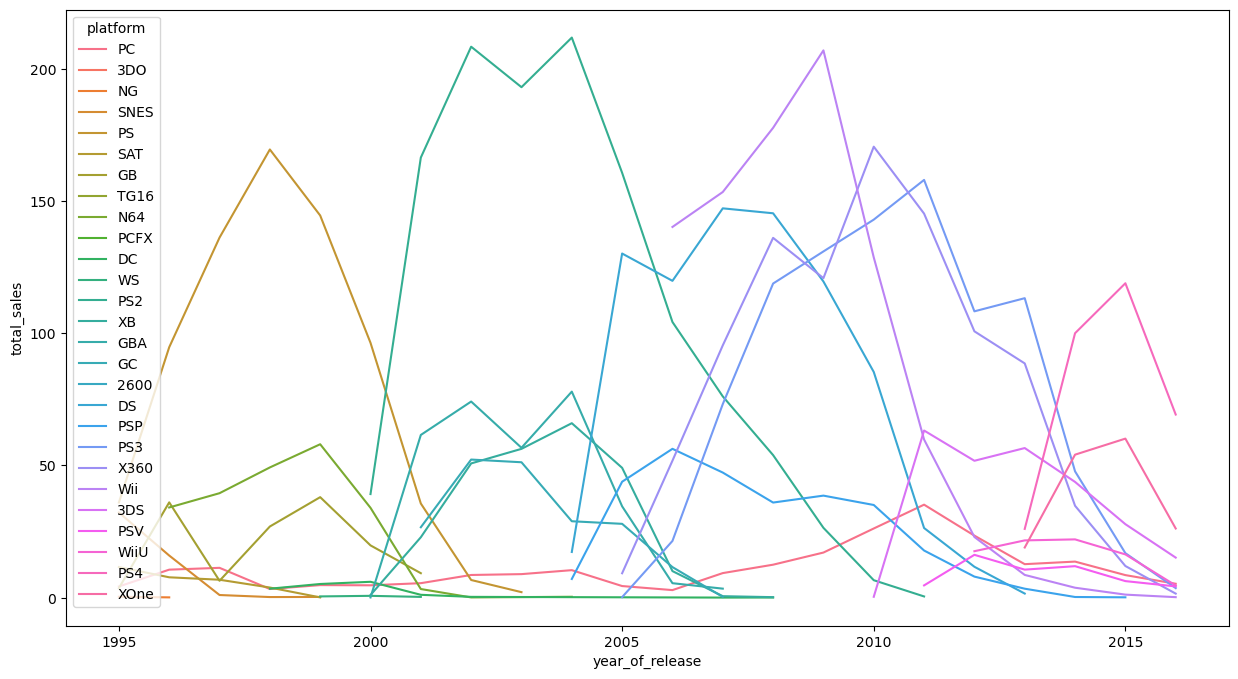

In [51]:
df_platform_by_years=df_since_1995.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index().sort_values(by='year_of_release')

plt.figure(figsize=(15,8))
ax = sns.lineplot(data=df_platform_by_years, x="year_of_release", y="total_sales",hue="platform")

We see, that average life cycle of platform is 6 years. On this line plot we see, that needs 1-2 years to reach the top of sales, and then we see the gradual fading.

5. Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017. Work only with the data that you've decided is relevant. Disregard the data for previous years.

As we saw on "Lollypop for Released Games" graph above we have peak of games in 2008, and then a downtrend. The most relevant dates for us is since 2014. (It is uncommon to use data for more than 2-3 years when forecasting next year's sales, even in case of traditional businesses. And in the dynamic computer games industry, taking longer time intervals should be avoided as it will definitely lead to tracking some obsolete trends. But we shouldn't take too short a period either.)

In [52]:
df_since_2014=df[df.year_of_release>=2014]
df_since_2014

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


6. Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.

In [53]:
df_sales_by_platforms=pd.pivot_table(df_since_2014,index='year_of_release',columns='platform',values='total_sales',aggfunc='sum',fill_value=0)
df_sales_by_platforms

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014.0,43.76,13.63,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015.0,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016.0,15.14,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


In [54]:
dynamics=(df_sales_by_platforms-df_sales_by_platforms.shift(+1)).T
dynamics

year_of_release,2014.0,2015.0,2016.0
platform,,,
3DS,NaN,-15.98,-12.64
PC,NaN,-5.11,-3.27
PS3,NaN,-30.94,-13.22
PS4,NaN,18.90,-49.65
PSP,NaN,-0.12,-0.12
PSV,NaN,-5.65,-2.00
Wii,NaN,-2.61,-0.96
WiiU,NaN,-5.68,-11.75
X360,NaN,-22.78,-10.44


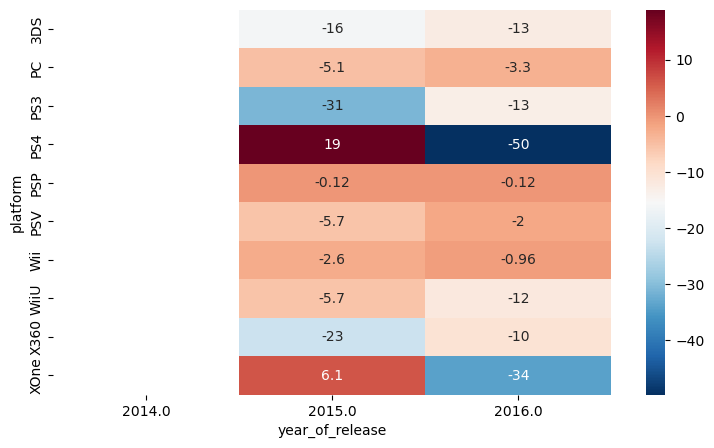

In [55]:
plt.figure(figsize=(9,5))
sns.heatmap(dynamics, cmap='RdBu_r', annot=True)
plt.show()

Here we see, that PS4 and XOne were growings, except 2016, but we don't have completed data for this year.

Other platforms were shrinking, expecially X360 and PS3. This happens because those two platforms had their peak approximately at 2012

7. Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.

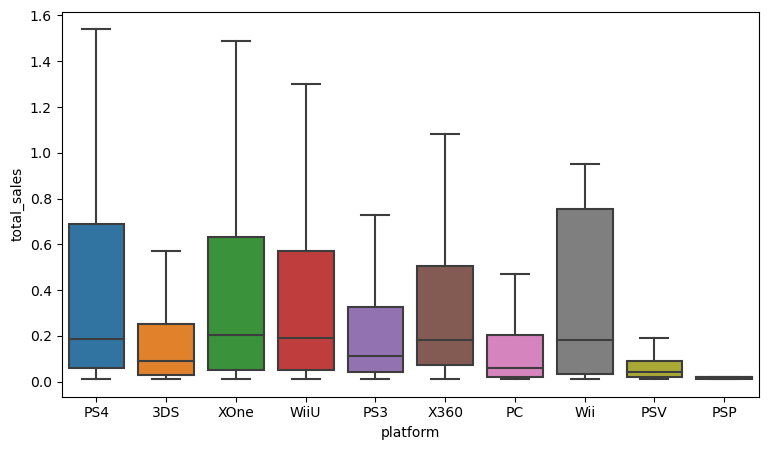

In [56]:
plt.figure(figsize=(9,5))
sns.boxplot(x='platform',y='total_sales',data=df_since_2014, showfliers = False)
plt.show()

In [57]:
order=df_since_2014.groupby(['platform'])['total_sales'].sum().reset_index().sort_values(by='total_sales')['platform']
order

4     PSP
6     Wii
5     PSV
1      PC
7    WiiU
8    X360
2     PS3
0     3DS
9    XOne
3     PS4
Name: platform, dtype: object

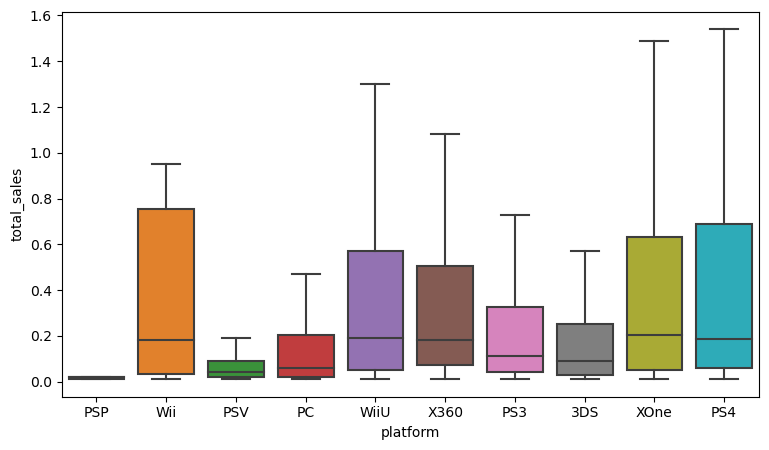

In [58]:
plt.figure(figsize=(9,5))
sns.boxplot(x='platform',y='total_sales',data=df_since_2014, order = order, showfliers = False)
plt.show()

Differences in sales significant, also 3 most profitable platforms brought most money per game.

From the analysis we see that the most promising platforms are PS4, PS3, X360 and XOne.
But from analysis of platform lifetimes we understand, that new platforms will rise (PS4 and XOne), while peak of old platforms has already passed (PS3 nad X360). So the main focus should be on PS4 and XOne games.

8. Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

In [59]:
def score_effect(platform,score_type):
    data=df_since_2014[(df_since_2014.platform==platform)&(df_since_2014[score_type].notna())][['total_sales',score_type]]
    data.plot(x=score_type, y='total_sales', kind='scatter')
    plt.title(f'Correlation between {score_type} and total sales of {platform}')
    correlation1=data.corr()
    correlation2=correlation1.total_sales[1]
    if correlation2 * correlation2 / correlation2 > 0.4 :
        result=f"Correlation between {score_type} and total sales is {correlation2}, that's mean, that we have correlation "
    else:
        result=f"Correlation between {score_type} and total sales is {correlation2}, that's mean, that we have no correlation"
    print(result)

Correlation between user_score and total sales is -0.040131589472697154, that's mean, that we have no correlation


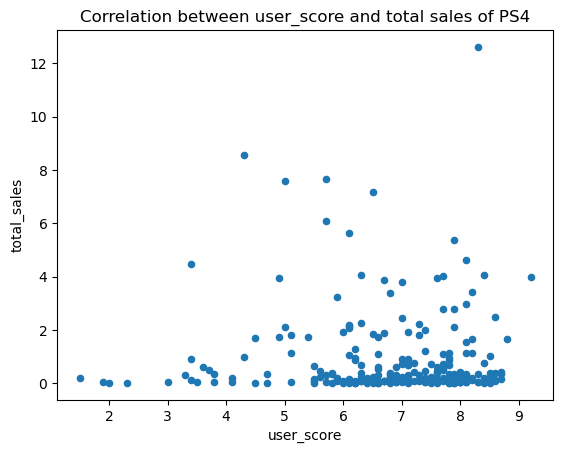

In [60]:
score_effect('PS4','user_score')

Correlation between critic_score and total sales is 0.40266141068104155, that's mean, that we have correlation 


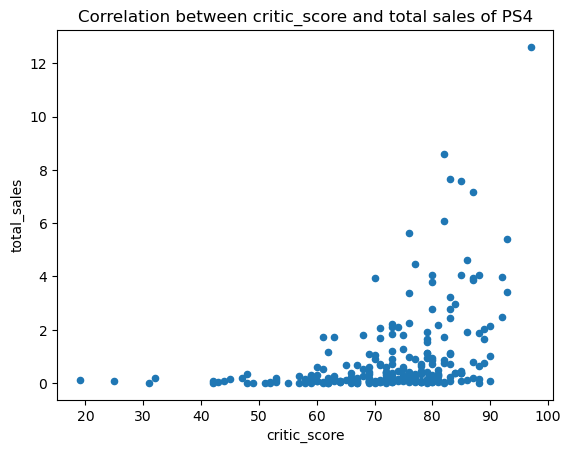

In [61]:
score_effect('PS4','critic_score')

Statistics tell us, that user_score doesn't affect on sales. And critic_score have some correlation with sales.

9. Keeping your conclusions in mind, compare the sales of the same games on other platforms.

I'll do it for PS3 and X360

Correlation between user_score and total sales is -0.16676141347662113, that's mean, that we have no correlation


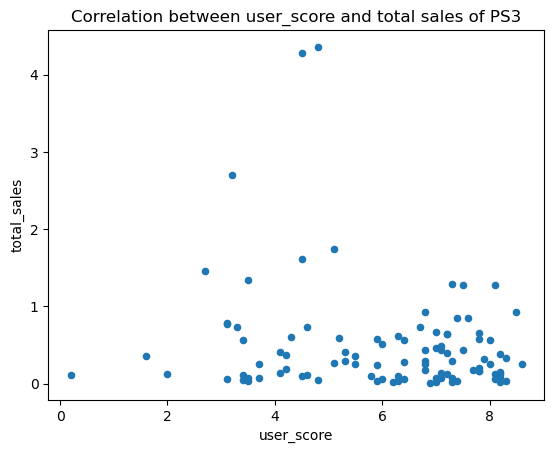

In [62]:
score_effect('PS3','user_score')

Correlation between critic_score and total sales is 0.44657460493190787, that's mean, that we have correlation 


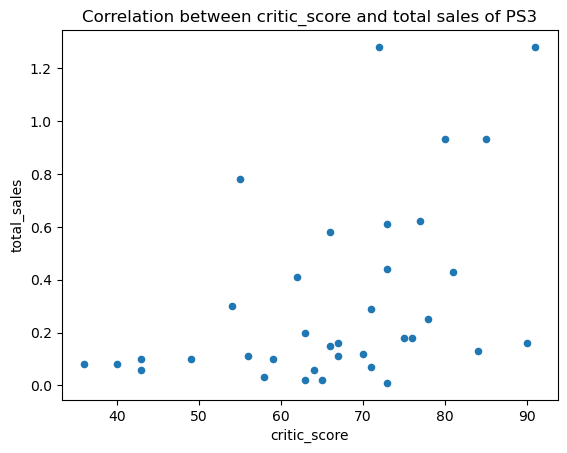

In [63]:
score_effect('PS3','critic_score')

Correlation between user_score and total sales is -0.13844457094566492, that's mean, that we have no correlation


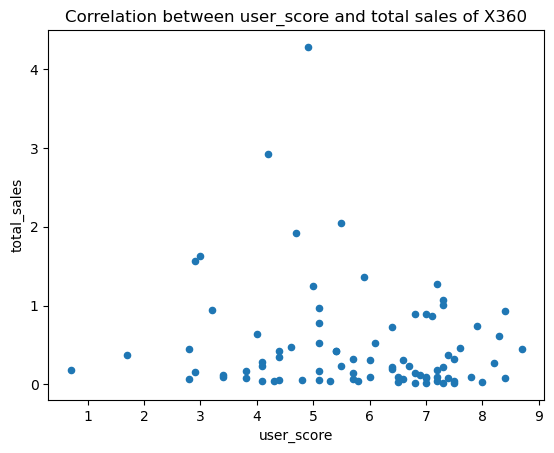

In [64]:
score_effect('X360','user_score')

Correlation between critic_score and total sales is 0.5257228356581524, that's mean, that we have correlation 


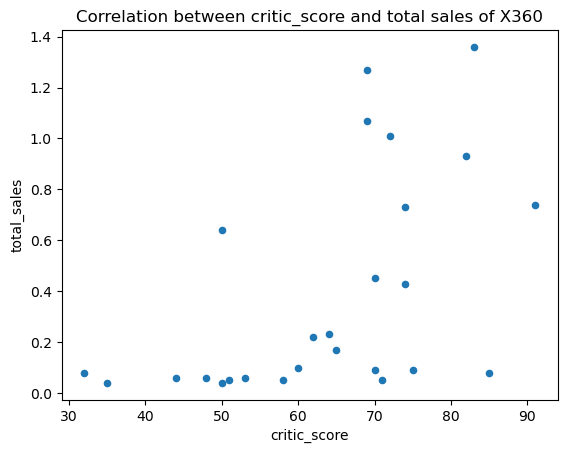

In [65]:
score_effect('X360','critic_score')

We see the same picture for those platforms. Correlations of critic scores and total sales less, than for PS4, but it's still there.

10. Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

In [66]:
grouped01 = df_since_2014.groupby(['genre'])['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False)

In [67]:
grouped02 = df_since_2014.groupby(['genre'])['name'].agg(['count']).sort_values(by='count', ascending=False)

In [68]:
grouped03 = grouped01.merge(grouped02, on='genre')
grouped03['avg_per_game'] = grouped03['sum'] / grouped03['count']
grouped03

,sum,count,avg_per_game
genre,,,
Action,199.71,620,0.322113
Shooter,170.94,128,1.335469
Sports,109.48,161,0.680000
Role-Playing,101.44,221,0.459005
Misc,37.55,113,0.332301
Fighting,28.22,60,0.470333
Racing,27.52,69,0.398841
Platform,18.09,38,0.476053
Adventure,17.55,185,0.094865


The most popular genre is Action, there are most count of games and most profitable as genre. But each game in average most profitable in genre Shooter.

3 worst by sales genres are Adventure, Strategy and Puzzle. They not only not popular with not many count of games, also they brought the least profit as genre and as average per game.

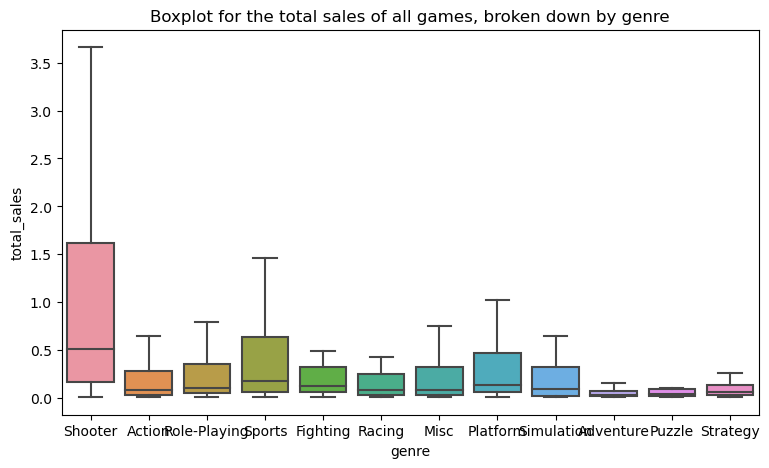

In [69]:
plt.figure(figsize=(9,5))
sns.boxplot(x = 'genre', y = 'total_sales', data = df_since_2014, showfliers = False)
plt.title('Boxplot for the total sales of all games, broken down by genre')
plt.show()

From this boxplot we see that the best genres regarding sales are Shooter, Sports and Platform.
Action is not so good, because number of games is big, but each game in average brought less profit. (this is what we saw in previous table in 'avg_per_game' column.

<div style="padding: 15px;">
<b>Create a user profile for each region</b></div>

For each region (NA, EU, JP), determine:

-The top five platforms. Describe variations in their market shares from region to region.

-The top five genres. Explain the difference.

-Do ESRB ratings affect sales in individual regions?

In [70]:
df_platform_regions = df_since_2014.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum().sort_values(by=['na_sales'], ascending=False).reset_index()
df_platform_regions

,platform,na_sales,eu_sales,jp_sales
0,PS4,98.61,130.04,15.02
1,XOne,81.27,46.25,0.32
2,X360,28.30,15.49,0.08
3,3DS,22.64,16.12,44.24
4,PS3,22.05,25.54,11.22
5,WiiU,19.36,13.15,7.31
6,PC,7.29,18.22,0.00
7,PSV,2.52,3.53,14.54
8,Wii,2.08,2.59,0.00
9,PSP,0.00,0.00,0.36


In [71]:
df_platform_regions['na_sales%']=df_platform_regions['na_sales']/df_platform_regions['na_sales'].sum()*100
df_platform_regions['eu_sales%']=df_platform_regions['eu_sales']/df_platform_regions['eu_sales'].sum()*100
df_platform_regions['jp_sales%']=df_platform_regions['jp_sales']/df_platform_regions['jp_sales'].sum()*100
df_platform_regions

,platform,na_sales,eu_sales,jp_sales,na_sales%,eu_sales%,jp_sales%
0,PS4,98.61,130.04,15.02,34.707166,47.997638,16.134923
1,XOne,81.27,46.25,0.32,28.604111,17.070830,0.343753
2,X360,28.30,15.49,0.08,9.960580,5.717344,0.085938
3,3DS,22.64,16.12,44.24,7.968464,5.949876,47.523902
4,PS3,22.05,25.54,11.22,7.760805,9.426789,12.052852
5,WiiU,19.36,13.15,7.31,6.814022,4.853652,7.852616
6,PC,7.29,18.22,0.00,2.565817,6.724984,0.000000
7,PSV,2.52,3.53,14.54,0.886949,1.302920,15.619293
8,Wii,2.08,2.59,0.00,0.732085,0.955966,0.000000
9,PSP,0.00,0.00,0.36,0.000000,0.000000,0.386723


In [72]:
def top_five(region):
    new_df_platform_regions = df_platform_regions.sort_values(by=region, ascending=False)
    labels = new_df_platform_regions['platform'].head()
    legend_label_list = new_df_platform_regions[f'{region}%'].head().tolist()
    form_legend_label_list = [ '%.2f' % elem for elem in legend_label_list ]
    explode = [0.1,0,0,0,0]
    plt.figure(figsize=(5,5))
    plt.pie(new_df_platform_regions[region].head(), labels = labels, explode = explode)
    plt.title(f'TOP 5 in {region[:2].upper()} region')
    plt.legend(form_legend_label_list, bbox_to_anchor =(1.55, 0.4), title='Percentage of all games:', loc = 'lower right')
    plt.show()

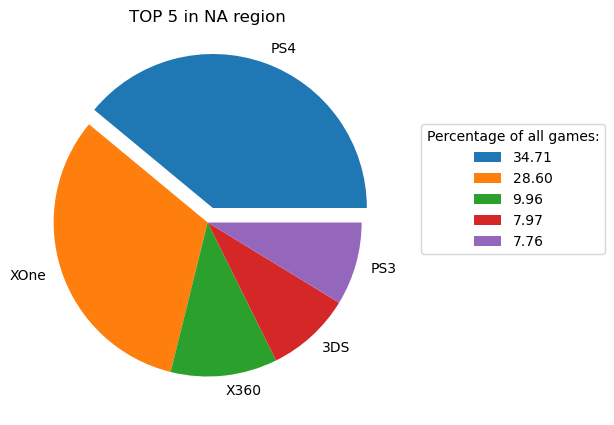

In [73]:
top_five('na_sales')

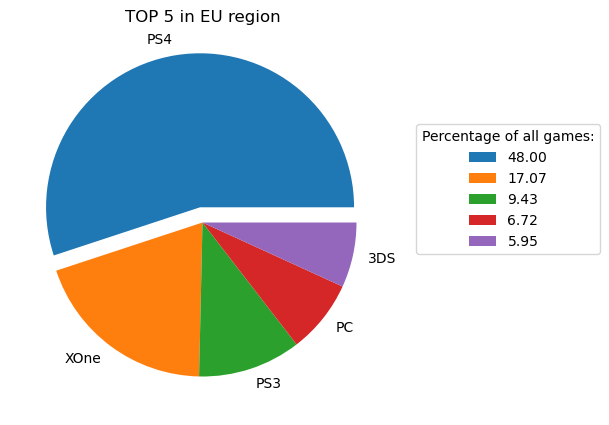

In [74]:
top_five('eu_sales')

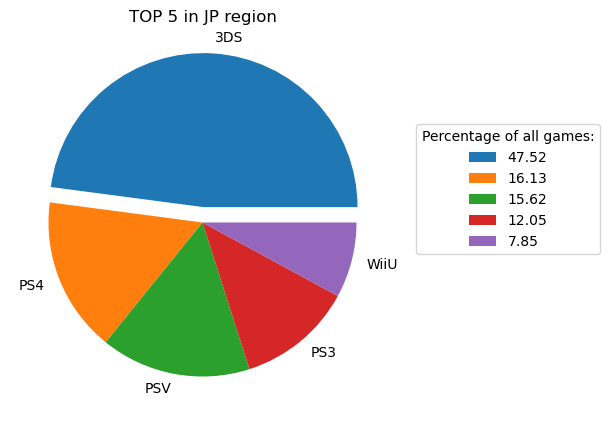

In [75]:
top_five('jp_sales')

Most popular in NA and EU regions are PS4 and XOne.

JP region is totally different: 3DS lead by a wide margin, PS4 hold 2nd place and 3rd is PSV.

In [76]:
df_genres_regions = df_since_2014.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum().sort_values(by=['na_sales'], ascending=False).reset_index()
df_genres_regions

,genre,na_sales,eu_sales,jp_sales
0,Shooter,79.02,65.52,4.87
1,Action,72.59,74.93,29.58
2,Sports,46.13,45.73,3.26
3,Role-Playing,33.47,28.17,31.16
4,Misc,15.05,12.86,5.61
5,Fighting,12.43,6.69,6.37
6,Racing,8.74,14.13,1.76
7,Platform,6.79,6.80,2.69
8,Adventure,5.64,6.49,3.60
9,Simulation,2.63,7.30,2.31


In [77]:
df_genres_regions['na_sales%']=df_genres_regions['na_sales']/df_genres_regions['na_sales'].sum()*100
df_genres_regions['eu_sales%']=df_genres_regions['eu_sales']/df_genres_regions['eu_sales'].sum()*100
df_genres_regions['jp_sales%']=df_genres_regions['jp_sales']/df_genres_regions['jp_sales'].sum()*100
df_genres_regions

,genre,na_sales,eu_sales,jp_sales,na_sales%,eu_sales%,jp_sales%
0,Shooter,79.02,65.52,4.87,27.812192,24.183368,5.231496
1,Action,72.59,74.93,29.58,25.549064,27.656590,31.775701
2,Sports,46.13,45.73,3.26,16.236097,16.878899,3.501987
3,Role-Playing,33.47,28.17,31.16,11.780234,10.397520,33.472983
4,Misc,15.05,12.86,5.61,5.297058,4.746614,6.026426
5,Fighting,12.43,6.69,6.37,4.374912,2.469273,6.842840
6,Racing,8.74,14.13,1.76,3.076165,5.215369,1.890643
7,Platform,6.79,6.80,2.69,2.389835,2.509873,2.889677
8,Adventure,5.64,6.49,3.60,1.985077,2.395453,3.867225
9,Simulation,2.63,7.30,2.31,0.925665,2.694423,2.481470


In [78]:
def top_five_genres(region):
    new_df_genres_regions = df_genres_regions.sort_values(by=region, ascending=False)
    labels = new_df_genres_regions['genre'].head()
    legend_label_list = new_df_genres_regions[f'{region}%'].head().tolist()
    form_legend_label_list = [ '%.2f' % elem for elem in legend_label_list ]
    explode = [0.1,0,0,0,0]
    plt.figure(figsize=(5,5))
    plt.pie(new_df_genres_regions[region].head(), labels = labels, explode = explode)
    plt.title(f'TOP 5 genres in {region[:2].upper()} region')
    plt.legend(form_legend_label_list, bbox_to_anchor =(1.55, 0.4), title='Percentage of all games:', loc = 'lower right')
    plt.show()

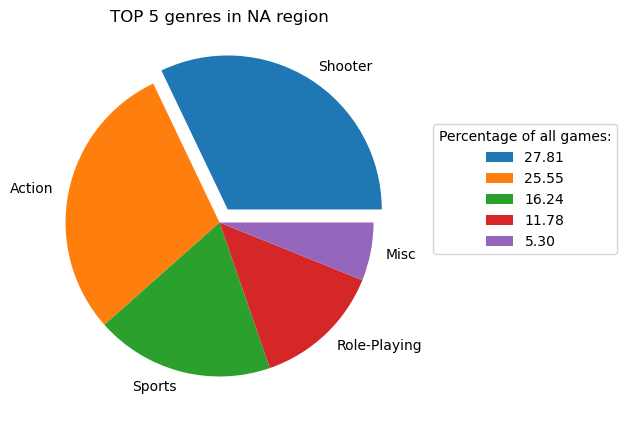

In [79]:
top_five_genres('na_sales')

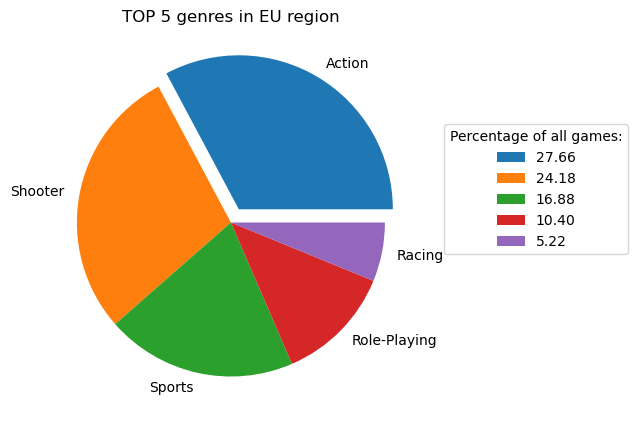

In [80]:
top_five_genres('eu_sales')

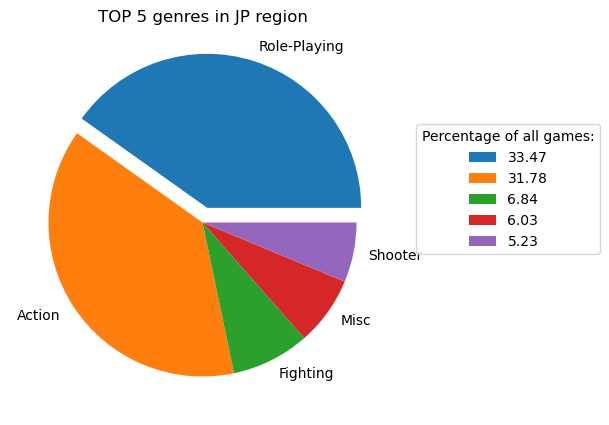

In [81]:
top_five_genres('jp_sales')

Here we see almost the same picture, in NA and EU regions top3 is the same - Action, Shooter and Sports.

In JP region 1st is Role-Playing, then Action and 3rd is Fighting.

In [82]:
df_rating_regions = df_since_2014.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().sort_values(by=['na_sales'], ascending=False).reset_index()
df_rating_regions

,rating,na_sales,eu_sales,jp_sales
0,M,96.48,93.69,8.01
1,unknown,64.72,58.95,56.90
2,E,50.74,58.06,8.94
3,T,38.95,34.07,14.78
4,E10+,33.23,26.16,4.46


In [83]:
df_rating_regions['na_sales%']=df_rating_regions['na_sales']/df_rating_regions['na_sales'].sum()*100
df_rating_regions['eu_sales%']=df_rating_regions['eu_sales']/df_rating_regions['eu_sales'].sum()*100
df_rating_regions['jp_sales%']=df_rating_regions['jp_sales']/df_rating_regions['jp_sales'].sum()*100
df_rating_regions

,rating,na_sales,eu_sales,jp_sales,na_sales%,eu_sales%,jp_sales%
0,M,96.48,93.69,8.01,33.957483,34.580888,8.604576
1,unknown,64.72,58.95,56.90,22.779107,21.758388,61.123644
2,E,50.74,58.06,8.94,17.858651,21.429890,9.603609
3,T,38.95,34.07,14.78,13.708996,12.575204,15.877108
4,E10+,33.23,26.16,4.46,11.695762,9.655631,4.791062


In [84]:
def top_five_rating(region):
    new_df_rating_regions = df_rating_regions.sort_values(by=region, ascending=False)
    labels = new_df_rating_regions['rating'].head()
    legend_label_list = new_df_rating_regions[f'{region}%'].head().tolist()
    form_legend_label_list = [ '%.2f' % elem for elem in legend_label_list ]
    explode = [0.1,0,0,0,0]
    plt.figure(figsize=(5,5))
    plt.pie(new_df_rating_regions[region].head(), labels = labels, explode = explode)
    plt.title(f'TOP 5 rating in {region[:2].upper()} region')
    plt.legend(form_legend_label_list, bbox_to_anchor =(1.55, 0.4), title='Percentage of all games:', loc = 'lower right')
    plt.show()

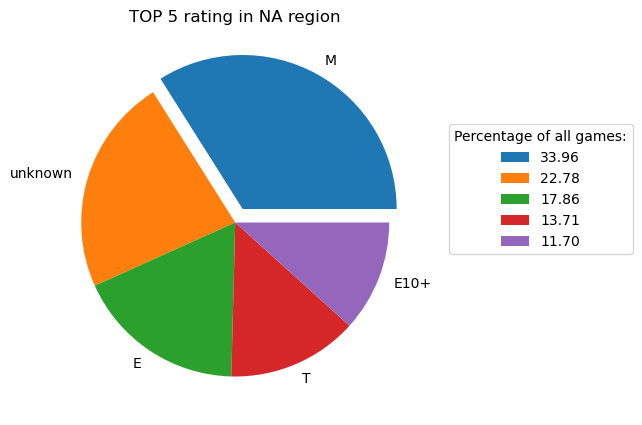

In [85]:
top_five_rating('na_sales')

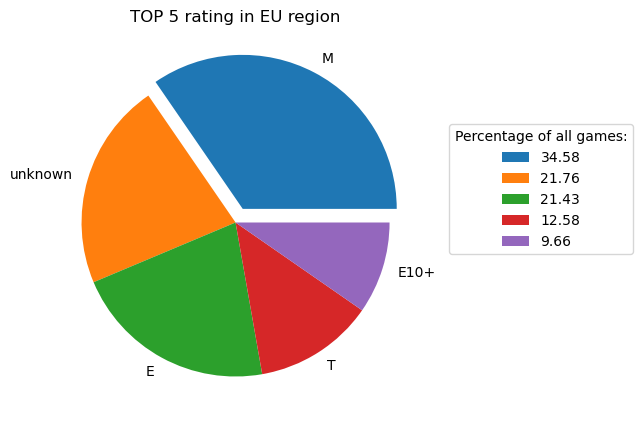

In [86]:
top_five_rating('eu_sales')

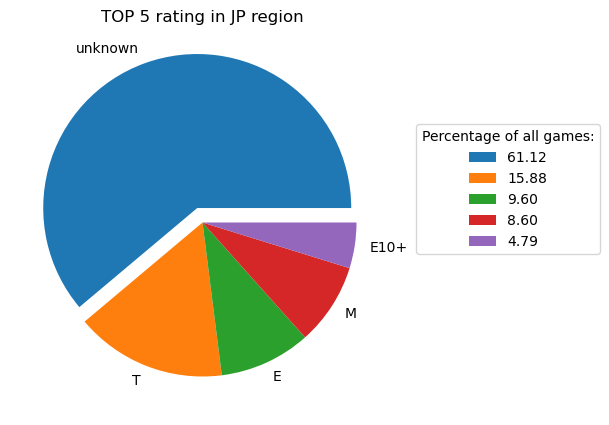

In [87]:
top_five_rating('jp_sales')

Regarding the rating, we also can see that NA and EU regions behave the same, and JP region has other top. And 'unknown' rating has a big impact on the data of JP region, because this rating system is applied mainly for the EU and NA regions.

<div style="padding: 15px;">
<b>Testing hypotheses</b></div>

1) Average user ratings of the Xbox One and PC platforms are the same

In [88]:
xone_rating = df_since_2014[(df_since_2014.platform=='XOne')&(df_since_2014.user_score.notna())]['user_score'].astype(float)
xone_rating

165      7.9
179      5.4
242      6.4
270      6.2
373      4.1
        ... 
16544    6.8
16597    6.0
16630    8.2
16643    6.6
16660    6.7
Name: user_score, Length: 165, dtype: float64

In [89]:
pc_rating = df_since_2014[(df_since_2014.platform=='PC')&(df_since_2014.user_score.notna())]['user_score'].astype(float)
pc_rating

458      3.9
1530     5.4
1730     7.9
2303     5.7
2784     5.9
        ... 
16456    8.3
16463    6.8
16509    7.9
16518    1.4
16692    7.6
Name: user_score, Length: 123, dtype: float64

In [90]:
stat, p = levene(xone_rating, pc_rating)
p<0.05

True

In [91]:
def t_test(x,y,alpha=0.05):
    p_value=stats.ttest_ind(x, y).pvalue
    print('P-Value is: ', p_value)
    if p_value<alpha:
        print(f'Reject H0: average of sample 1 is not equal to average sample 2')
    else:
        print(f"Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same.") 

In [92]:
t_test(xone_rating,pc_rating)

P-Value is:  0.1269024252036148
Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same.


In other words there is no significant difference in the means.

2) Average user ratings for the Action and Sports genres are different.

In [93]:
action_user_rating = df_since_2014[(df_since_2014.genre=='Action')&(df_since_2014.user_score.notna())]['user_score'].astype(float)
action_user_rating

42       8.3
165      7.9
231      8.1
295      6.3
304      4.9
        ... 
16544    6.8
16597    6.0
16652    8.5
16660    6.7
16692    7.6
Name: user_score, Length: 298, dtype: float64

In [94]:
sports_user_rating = df_since_2014[(df_since_2014.genre=='Sports')&(df_since_2014.user_score.notna())]['user_score'].astype(float)
sports_user_rating

77       4.3
94       5.0
143      5.7
264      4.5
314      6.7
        ... 
16120    6.3
16142    8.8
16146    6.9
16518    1.4
16643    6.6
Name: user_score, Length: 127, dtype: float64

In [95]:
stat, p = levene(action_user_rating, sports_user_rating)
p<0.05

True

In [96]:
t_test(action_user_rating,sports_user_rating)

P-Value is:  2.1177739029231719e-19
Reject H0: average of sample 1 is not equal to average sample 2


In other words average user ratings of the Actions and Sports are different.

<div style="padding: 15px;">
<b>General conclusion</b></div>

From our analysis, we learned that there was a peak in the number of games was in 2008, and for the last 4-5 years the value has returned to the average. 

Then we found out which platforms are the most profitable in the historical period and at the moment.

We carried out further analysis with data from 2014, because we found them relevant. We found out which platforms are profitable at the moment.

Also we found out that critic's scores can affect game sales, but user's scores have no effect. Next, we found out which genres of games are the most profitable and popular.

Then we found out that the behavior of the NA region and EU region markets is almost the same, but the JP market is very different.

At the end, we tested 2 hypotheses, and found out that average user ratings of the Xbox One and PC platforms are the same and average user ratings of the Actions and Sports are different.